In [75]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import random
from IPython.display import display
from datetime import datetime
game_results_df = pd.read_csv('./datasets/results.csv')

In [76]:
game_results_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45315 entries, 0 to 45314
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        45315 non-null  object
 1   home_team   45315 non-null  object
 2   away_team   45315 non-null  object
 3   home_score  45315 non-null  int64 
 4   away_score  45315 non-null  int64 
 5   tournament  45315 non-null  object
 6   city        45315 non-null  object
 7   country     45315 non-null  object
 8   neutral     45315 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


In [77]:
game_results = game_results_df.copy()
game_results.drop(columns=['city'],inplace=True,axis=1)
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False
...,...,...,...,...,...,...,...,...
45310,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,False
45311,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,False
45312,2023-11-21,Andorra,Israel,0,2,UEFA Euro qualification,Andorra,False
45313,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,False


In [78]:
game_results['home_code'] = game_results.home_team.astype('category').cat.codes
l = len(game_results['home_team'].values)
country_codes = {game_results['home_team'].values[i]:game_results['home_code'].values[i] for i in range(l)}
code = max(country_codes.values()) + 1
# encode_dict = game_results.['home_team']
def encode_away_teams(x):
   global code
   val = country_codes.setdefault(x, code)
   if val == code:
      code+=1
   return val
game_results['away_code'] = game_results.away_team.apply(lambda x: encode_away_teams(x)).copy()
game_results['hosting_country_code'] = game_results.country.apply(lambda x: encode_away_teams(x)).copy()
game_results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,238,82,238
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,82,238,82
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,238,82,238
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,82,238,82
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False,238,82,238


Since we only have fifa rankings starting from 1992-12-31, we'll be only keeping games from 1993-Present

In [79]:
game_results['date'] = pd.to_datetime(game_results['date'],format='%Y-%m-%d')
# Convert 'neutral' column to boolean format (1 for True, 0 for False)
game_results['neutral'] = game_results['neutral'].astype(int)

# Display the 'neutral' column to verify the changes
game_results['neutral'].head()
game_results.tournament.value_counts()

tournament
Friendly                                17773
FIFA World Cup qualification             8016
UEFA Euro qualification                  2815
African Cup of Nations qualification     1998
FIFA World Cup                            964
                                        ...  
Copa Confraternidad                         1
FIFA 75th Anniversary Cup                   1
Real Madrid 75th Anniversary Cup            1
Évence Coppée Trophy                        1
The Other Final                             1
Name: count, Length: 147, dtype: int64

In [80]:
game_results.dtypes

date                    datetime64[ns]
home_team                       object
away_team                       object
home_score                       int64
away_score                       int64
tournament                      object
country                         object
neutral                          int64
home_code                        int16
away_code                        int64
hosting_country_code             int64
dtype: object

In [81]:
game_results['final_score'] = game_results.apply(lambda x: 2 if x.away_score < x.home_score else 0 if x.away_score > x.home_score else 1,axis=1)

In [82]:
game_results.reset_index(level=0,inplace=True)
game_results.drop('index',inplace=True,axis=1)
game_results['final_score'].value_counts()


final_score
2    22060
0    12838
1    10417
Name: count, dtype: int64

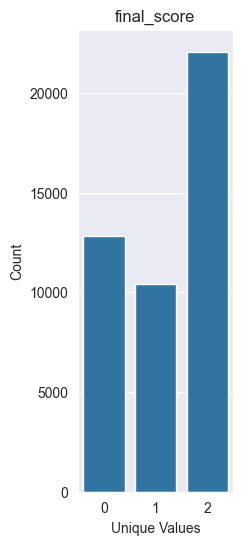

In [83]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 6))
sns.countplot(x='final_score', data=game_results)
plt.title('final_score')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

We have heavy data imbalance where there are more home wins are alot higher than losses or ties. We'll probably need to either undersample the wins or oversample the ties/losses.

In [84]:
game_results.tournament.value_counts()

tournament
Friendly                                17773
FIFA World Cup qualification             8016
UEFA Euro qualification                  2815
African Cup of Nations qualification     1998
FIFA World Cup                            964
                                        ...  
Copa Confraternidad                         1
FIFA 75th Anniversary Cup                   1
Real Madrid 75th Anniversary Cup            1
Évence Coppée Trophy                        1
The Other Final                             1
Name: count, Length: 147, dtype: int64

We need to limit the tournament categories to just three: 
- Cup
- Tournament
- Friendly

In [85]:
def decide_competition(match_type):
   # Superclasico is a south american friendly
    if match_type.lower() == 'friendly' or match_type.lower().find('superclásico') != -1:
        return 2
    tournament_names = ['tournoi','uefa','tournament','qualifications','qualification','games','festival','league']
    cup_names = ['cup', 'final','championship','copa']
   # Tournament - 0
    for x in tournament_names:
        if match_type.lower().find(x) != -1:
            return 0
   # Cup - 1
    for x in cup_names:
        if match_type.lower().find(x) != -1:
            return 1
    return 2

### Reorganize the tournaments to either be a cup, tournament, or friendly
Encodes the three values: 
- Tournament $\rightarrow0$
- Cup $\rightarrow1$
- Friendly $\rightarrow2$

In [86]:
game_results['tournament_code'] = game_results['tournament'].apply(decide_competition)

In [87]:
game_results['tournament_code'] = game_results.tournament_code.astype(int)
game_results['tournament_code'].value_counts()

tournament_code
2    17803
0    17635
1     9877
Name: count, dtype: int64

Seems like we have much more tournament matches. We might need to oversample cup games later if the results aren't good

### Test run..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45315 entries, 0 to 45314
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   neutral               45315 non-null  int64
 1   home_code             45315 non-null  int16
 2   away_code             45315 non-null  int64
 3   hosting_country_code  45315 non-null  int64
 4   tournament_code       45315 non-null  int64
dtypes: int16(1), int64(4)
memory usage: 1.5 MB
Accuracy (Logistic Regression): 0.5106289076866495
F1-Score: 0.3004216042471644
Accuracy: 0.51


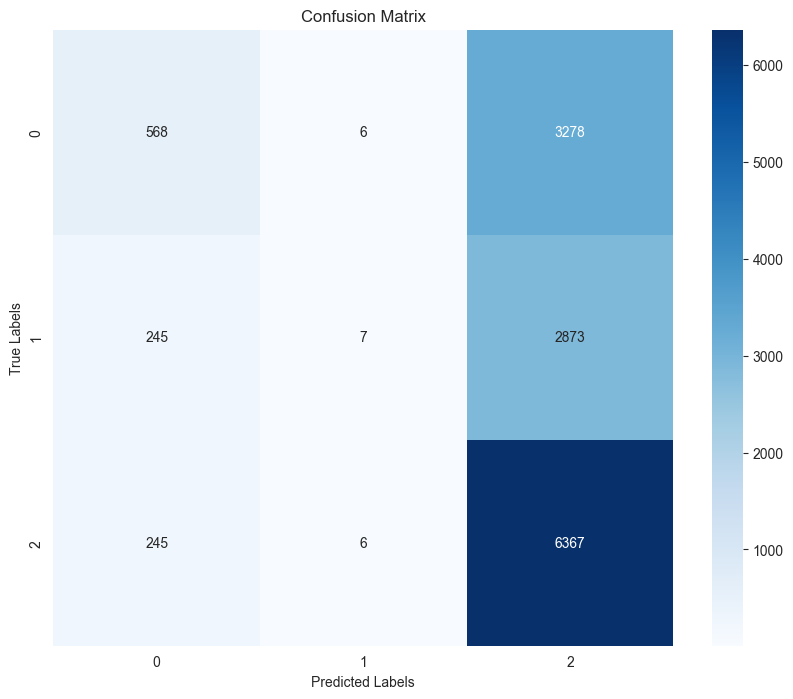

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
test_me = True
if test_me:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
    
    game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date'],axis=1)
    X = game_results_ready.drop(['final_score'], axis=1)
    y = game_results_ready['final_score']
    X.info()
    # Splitting of Data - 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
    # svm = svm_ovo = SVC(decision_function_shape='ovo', kernel='linear')
    lr = GradientBoostingClassifier(n_estimators=100, random_state=42)
    # svm_ovo.fit(X_train, y_train)
    lr.fit(X_train,y_train)
    # y_pred_ovo = svm_ovo.predict(X_test)
    y_pred_lr = lr.predict(X_test)
    # accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
    # f1_ovo = f1_score(y_test,y_pred_ovo,average='macro')
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    conf_mat = confusion_matrix(y_test,y_pred_lr)
    f1_lr = f1_score(y_test,y_pred_lr,average='macro')
    # print(f"Accuracy (One-vs-One): {accuracy_ovo}")
    # print(f'F1-Score: {f1_ovo}')
    print(f"Accuracy (Logistic Regression): {accuracy_lr}")
    print(f'F1-Score: {f1_lr}')
    
    accuracy = accuracy_score(y_test, y_pred_lr)
    print(f"Accuracy: {accuracy:.2f}")
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Plot a heatmap of the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=lr.classes_, yticklabels=lr.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### Get the most recent FIFA rank at the time of match

In [89]:
game_results['home_advantage'] = 0
game_results.loc[game_results['home_code'] == game_results['hosting_country_code'], 'home_advantage'] = 1
game_results['home_advantage'].value_counts()

home_advantage
1    33217
0    12098
Name: count, dtype: int64

### Now to check historical head-to-head matches between the two teams


In [90]:
# Create a new column 'head_to_head_last_5' with default value 0
game_results['head_to_head_last_5'] = 0

# Define a function to calculate the number of wins for the home team against the away team in the last 5 matches

# This is too slow so we'll only use it for rows later
def calculate_head_to_head(row):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[
        ((game_results['home_team'] == home_team) & (game_results['away_team'] == away_team)) |
        ((game_results['home_team'] == away_team) & (game_results['away_team'] == home_team))
    ]
    
    # Sort the subset by date
    relevant_matches = relevant_matches.sort_values(by='date')
    
    # Consider only the last 5 matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Count the number of wins for the home team
    wins_home_team = last_5_matches[
        (last_5_matches['home_team'] == home_team) &
        (last_5_matches['final_score'] == 2)
    ].shape[0] 
    
    return wins_home_team

# Apply the function to calculate the head-to-head performance for each row
# game_results['head_to_head_last_5'] = game_results.apply(calculate_head_to_head, axis=1)
# game_results['head_to_head_last_5'].value_counts()
# Create a new column 'head_to_head_last_5' with default value 0
game_results['head_to_head_last_5'] = 0

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Combine home and away teams to create a unique identifier for each match, TEMPORARY
game_results['match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)

# Group by match and calculate the cumulative sum of wins for the home team (final_score == 2) using rolling window
game_results['head_to_head_last_5'] = game_results.groupby('match_id')['final_score'].rolling(window=5, min_periods=1).apply(lambda x: (x == 2).sum(), raw=True).reset_index(drop=True)

# Subtract the current match's wins to get the last 5 matches
game_results['head_to_head_last_5'] = (game_results['head_to_head_last_5'] - (game_results['final_score'] == 2))
# Clip the values to ensure the minimum is 0
game_results['head_to_head_last_5'] = game_results['head_to_head_last_5'].clip(lower=0)
# Ensure 'head_to_head_last_5' is of integer type
game_results['head_to_head_last_5'] = game_results['head_to_head_last_5'].astype(int)

# Display value counts
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,home_advantage,head_to_head_last_5,match_id
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,0,238,82,238,1,2,1,0,England_Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,England,0,82,238,82,2,2,1,0,England_Scotland
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,0,238,82,238,2,2,1,0,England_Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,England,0,82,238,82,1,2,1,1,England_Scotland
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,0,238,82,238,2,2,1,0,England_Scotland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45281,2023-11-21,Hong Kong,Turkmenistan,2,2,FIFA World Cup qualification,Hong Kong,0,121,280,121,1,0,1,2,Hong Kong_Turkmenistan
45282,2023-11-21,Philippines,Indonesia,1,1,FIFA World Cup qualification,Philippines,0,211,125,211,1,0,1,1,Indonesia_Philippines
45283,2023-11-21,Vietnam,Iraq,0,1,FIFA World Cup qualification,Vietnam,0,294,127,294,0,0,1,1,Iraq_Vietnam
45285,2023-11-21,Jordan,Saudi Arabia,0,2,FIFA World Cup qualification,Jordan,0,137,237,137,0,0,1,1,Jordan_Saudi Arabia


### Get the difference in rank between the two teams
Negative value indicates that home team's rank is better than away team. Value itself shows how far apart they are.

0 -> Home loss,<br>
1 -> Tie,<br>
2 -> Home win

### Now another goal difference column that looks at the previous 5 matches for both teams
Checks the goals scored by the team and goals conceded, subtracts them to get the delta. Negative value indicates that a team concedes more than they score.

In [91]:
# Define a function to calculate the goal difference for the home team in the last five matches'

# Slow!
def calculate_goal_difference_last_5(row, team_type):
    team = row[team_type]
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[game_results[team_type] == team]
    
    # Sort the subset by date
    relevant_matches = relevant_matches.sort_values(by='date')
    
    # Consider only the last five matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Calculate the total goals scored by the team in the last five matches
    goals_scored = last_5_matches['{}_score'.format('home' if team_type == 'home_team' else 'away')].sum()
    # Calculate the total goals scored against the team in the last five matches
    goals_conceded = last_5_matches['{}_score'.format('home' if team_type == 'away_team' else 'away')].sum()
    # Calculate the goal difference
    goal_difference = goals_scored - goals_conceded
    
    return goal_difference

# Apply the function to calculate the goal difference for the home team in the last five matches for each row
# TODO - USE MAPPED HOME TEAM?
# Create new columns 'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away'
game_results['scored_last_5_home'] = 0
game_results['conceded_last_5_home'] = 0
game_results['scored_last_5_away'] = 0
game_results['conceded_last_5_away'] = 0

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Group by home_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_home'] = game_results.groupby('home_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_home'] = game_results.groupby('home_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Group by away_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_away'] = game_results.groupby('away_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_away'] = game_results.groupby('away_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Ensure 'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away' are of integer type
game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']] = game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']].astype(int)

# Calculate goal difference for home and away teams
game_results['goal_difference_last_5_home'] = game_results['scored_last_5_home'] - game_results['conceded_last_5_home']
game_results['goal_difference_last_5_away'] = game_results['scored_last_5_away'] - game_results['conceded_last_5_away']

# Display value counts
game_results.tail()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,tournament_code,home_advantage,head_to_head_last_5,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away
45309,2023-11-21,Greece,France,2,2,UEFA Euro qualification,Greece,0,106,93,...,0,1,0,France_Greece,10,7,7,7,3,0
45310,2023-11-21,Wales,Turkey,1,1,UEFA Euro qualification,Wales,0,296,279,...,0,1,0,Turkey_Wales,9,8,7,9,1,-2
45311,2023-11-21,Croatia,Armenia,1,0,UEFA Euro qualification,Croatia,0,66,13,...,0,1,0,Armenia_Croatia,7,9,7,10,-2,-3
45286,2023-11-21,Bahrain,United Arab Emirates,0,2,FIFA World Cup qualification,Bahrain,0,21,285,...,0,1,1,Bahrain_United Arab Emirates,0,4,3,4,-4,-1
45314,2023-11-21,Romania,Switzerland,1,0,UEFA Euro qualification,Romania,0,222,261,...,0,1,0,Romania_Switzerland,6,9,6,7,-3,-1


In [92]:
game_results['goal_difference_last_5_home'].value_counts() # This seems fishy

goal_difference_last_5_home
 3     3465
 4     3322
 2     3313
 1     3163
 5     2944
       ... 
-57       1
-53       1
 67       1
 64       1
 37       1
Name: count, Length: 92, dtype: int64

### Weird value?
There seems to be a team that has a goal difference of 67... Meaning they scored at least 67 goals in the last 5 games? Let's investigate that team

In [93]:
# Let's find that team
game_results[game_results['goal_difference_last_5_home'] == 67]

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,tournament_code,home_advantage,head_to_head_last_5,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away
2023,1937-10-05,Austria,Latvia,2,1,FIFA World Cup qualification,Austria,0,17,148,...,0,1,2,Austria_Latvia,67,0,11,14,67,-3


### Australia had a goal diff. of 67 on June 2001. Let's look at their matches that happened before that game.
67 goals across 5 games means an average of 13 goals per game. Let's find any matches with > 10 goals scored by the home team and look at the last 5.

In [94]:
game_results.loc[((game_results['home_team'] == 'Australia') | (game_results['away_team'] == 'Australia')) & (game_results['date'] < '2001-06-02') & (game_results['home_score'] > 10)].tail(5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,tournament_code,home_advantage,head_to_head_last_5,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away
21923,1998-09-28,Australia,Cook Islands,16,0,Oceania Nations Cup,Australia,0,16,62,...,1,1,1,Australia_Cook Islands,3,8,4,16,-5,-12
23394,2000-06-19,Australia,Cook Islands,17,0,Oceania Nations Cup,French Polynesia,1,16,62,...,1,0,2,Australia_Cook Islands,6,8,5,5,-2,0
24157,2001-04-09,Australia,Tonga,22,0,FIFA World Cup qualification,Australia,0,16,276,...,0,1,0,Australia_Tonga,4,7,0,12,-3,-12
24160,2001-04-11,Australia,American Samoa,31,0,FIFA World Cup qualification,Australia,0,16,5,...,0,1,0,American Samoa_Australia,6,9,1,8,-3,-7
24176,2001-04-16,Australia,Samoa,11,0,FIFA World Cup qualification,Australia,0,16,234,...,0,1,0,Australia_Samoa,10,15,4,13,-5,-9


### Oh! Seems like that was not an error and it actually happened. Let's move on.

### Days since the last match played

In [95]:
# Create a new column 'days_since_last_match' to represent the days since the last match for each team
game_results['days_since_last_match_home'] = game_results.groupby('home_team')['date'].diff().dt.days
game_results['days_since_last_match_away'] = game_results.groupby('away_team')['date'].diff().dt.days

# Fill NaN values with a default value (e.g., 0)
game_results['days_since_last_match_home'] = game_results['days_since_last_match_home'].fillna(0)
game_results['days_since_last_match_away'] = game_results['days_since_last_match_away'].fillna(0)

game_results['days_since_last_match_home'].value_counts()

days_since_last_match_home
4.0       2559
3.0       2553
2.0       2524
7.0       1317
35.0      1233
          ... 
1983.0       1
3316.0       1
1288.0       1
4124.0       1
485.0        1
Name: count, Length: 1499, dtype: int64

In [96]:
game_results.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'home_code', 'away_code',
       'hosting_country_code', 'final_score', 'tournament_code',
       'home_advantage', 'head_to_head_last_5', 'match_id',
       'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away',
       'conceded_last_5_away', 'goal_difference_last_5_home',
       'goal_difference_last_5_away', 'days_since_last_match_home',
       'days_since_last_match_away'],
      dtype='object')

In [97]:
game_results.dtypes

date                           datetime64[ns]
home_team                              object
away_team                              object
home_score                              int64
away_score                              int64
tournament                             object
country                                object
neutral                                 int64
home_code                               int16
away_code                               int64
hosting_country_code                    int64
final_score                             int64
tournament_code                         int64
home_advantage                          int64
head_to_head_last_5                     int64
match_id                               object
scored_last_5_home                      int64
conceded_last_5_home                    int64
scored_last_5_away                      int64
conceded_last_5_away                    int64
goal_difference_last_5_home             int64
goal_difference_last_5_away       

In [98]:
# Let's look at Saudi Arabia's games
results = game_results.loc[('Saudi Arabia' == game_results['home_team'])]
display(results)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,head_to_head_last_5,match_id,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away
6777,1967-12-10,Saudi Arabia,Tunisia,4,0,Friendly,Saudi Arabia,0,237,278,...,2,Saudi Arabia_Tunisia,12,2,5,8,10,-3,0.0,952.0
7106,1969-01-17,Saudi Arabia,Turkey,1,2,Friendly,Saudi Arabia,0,237,279,...,2,Saudi Arabia_Turkey,1,9,5,12,-8,-7,404.0,86.0
7512,1970-03-28,Saudi Arabia,Kuwait,1,3,Gulf Cup,Bahrain,1,237,144,...,2,Kuwait_Saudi Arabia,4,4,0,2,0,-2,435.0,1450.0
7516,1970-04-02,Saudi Arabia,Qatar,1,1,Gulf Cup,Bahrain,1,237,216,...,0,Qatar_Saudi Arabia,6,6,8,14,0,-6,5.0,2.0
8241,1972-03-16,Saudi Arabia,Kuwait,2,2,Gulf Cup,Saudi Arabia,0,237,144,...,4,Kuwait_Saudi Arabia,9,8,9,4,1,5,714.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44326,2022-11-30,Saudi Arabia,Mexico,1,2,FIFA World Cup,Qatar,1,237,172,...,4,Mexico_Saudi Arabia,10,4,9,8,6,1,14.0,4.0
44376,2023-01-12,Saudi Arabia,Oman,1,2,Gulf Cup,Iraq,1,237,199,...,1,Oman_Saudi Arabia,8,9,10,5,-1,5,43.0,6.0
44433,2023-03-24,Saudi Arabia,Venezuela,1,2,Friendly,Saudi Arabia,0,237,293,...,2,Saudi Arabia_Venezuela,2,10,20,2,-8,18,71.0,124.0
44546,2023-03-28,Saudi Arabia,Bolivia,1,2,Friendly,Saudi Arabia,0,237,33,...,1,Bolivia_Saudi Arabia,6,7,7,4,-1,3,4.0,4.0


## Now we can work on the model

### We'll need to add more features to improve the results

In [99]:
# Define a function to calculate the number of wins in the last 10 games

# Slow
def calculate_wins_last_10(row):
    team = row['home_team']
    date = row['date']
    last_10_games = game_results[(game_results['home_team'] == team) | (game_results['away_team'] == team)]
    last_10_games = last_10_games[last_10_games['date'] < date].tail(10)
    wins = last_10_games['final_score'].eq(2).sum()  # 2 represents a home win
    return wins


# We'll create new columns 'wins_last_10_games_home' and 'wins_last_10_games_away' with NaN values
game_results['wins_last_10_games_home'] = pd.Series(dtype=float)
game_results['wins_last_10_games_away'] = pd.Series(dtype=float)

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Combine home and away teams to create a unique identifier for each match
game_results['home_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)
game_results['away_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['away_team'], row['home_team']])), axis=1)

# Define a function to calculate the rolling sum of wins in the last 10 games for each team
def calculate_rolling_wins_last_10(series):
    return (series == 2).rolling(window=10, min_periods=1).sum()

# Apply the rolling sum function to calculate wins in the last 10 games for home_team and away_team
game_results['wins_last_10_games_home'] = game_results.groupby('home_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)
game_results['wins_last_10_games_away'] = game_results.groupby('away_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)

# Ensure 'wins_last_10_games_home' and 'wins_last_10_games_away' are of integer type
game_results[['wins_last_10_games_home', 'wins_last_10_games_away']] = game_results[['wins_last_10_games_home', 'wins_last_10_games_away']].astype(int)
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,0,238,82,...,0,3,0,-3,0.0,0.0,0,1,England_Scotland,England_Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,England,0,82,238,...,2,4,0,-2,0.0,0.0,0,1,England_Scotland,England_Scotland
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,0,238,82,...,5,7,0,-2,462.0,462.0,0,1,England_Scotland,England_Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,England,0,82,238,...,7,9,-1,-2,728.0,728.0,0,1,England_Scotland,England_Scotland
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,0,238,82,...,7,9,8,-2,728.0,728.0,1,1,England_Scotland,England_Scotland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45280,2023-11-21,Uzbekistan,Iran,2,2,FIFA World Cup qualification,Uzbekistan,0,290,126,...,5,3,2,2,154.0,75.0,5,2,Iran_Uzbekistan,Iran_Uzbekistan
45281,2023-11-21,Hong Kong,Turkmenistan,2,2,FIFA World Cup qualification,Hong Kong,0,121,280,...,7,3,-1,4,40.0,70.0,4,2,Hong Kong_Turkmenistan,Hong Kong_Turkmenistan
45282,2023-11-21,Philippines,Indonesia,1,1,FIFA World Cup qualification,Philippines,0,211,125,...,6,2,-3,4,5.0,5.0,3,2,Indonesia_Philippines,Indonesia_Philippines
45265,2023-11-21,Canada,Jamaica,2,3,CONCACAF Nations League,Canada,0,46,134,...,13,7,5,6,140.0,10.0,6,1,Canada_Jamaica,Canada_Jamaica


### Refine the features to only include important ones
We get rid of `object` columns and `x_score` columns because giving the score makes no sense. We'll use `game_results_ready` in order to keep the original game_results dataframe for functions that use it.

In [100]:
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,0,238,82,...,0,3,0,-3,0.0,0.0,0,1,England_Scotland,England_Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,England,0,82,238,...,2,4,0,-2,0.0,0.0,0,1,England_Scotland,England_Scotland
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,0,238,82,...,5,7,0,-2,462.0,462.0,0,1,England_Scotland,England_Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,England,0,82,238,...,7,9,-1,-2,728.0,728.0,0,1,England_Scotland,England_Scotland
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,0,238,82,...,7,9,8,-2,728.0,728.0,1,1,England_Scotland,England_Scotland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45280,2023-11-21,Uzbekistan,Iran,2,2,FIFA World Cup qualification,Uzbekistan,0,290,126,...,5,3,2,2,154.0,75.0,5,2,Iran_Uzbekistan,Iran_Uzbekistan
45281,2023-11-21,Hong Kong,Turkmenistan,2,2,FIFA World Cup qualification,Hong Kong,0,121,280,...,7,3,-1,4,40.0,70.0,4,2,Hong Kong_Turkmenistan,Hong Kong_Turkmenistan
45282,2023-11-21,Philippines,Indonesia,1,1,FIFA World Cup qualification,Philippines,0,211,125,...,6,2,-3,4,5.0,5.0,3,2,Indonesia_Philippines,Indonesia_Philippines
45265,2023-11-21,Canada,Jamaica,2,3,CONCACAF Nations League,Canada,0,46,134,...,13,7,5,6,140.0,10.0,6,1,Canada_Jamaica,Canada_Jamaica


In [101]:
game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date','match_id','home_match_id','away_match_id'],axis=1)

In [102]:
game_results_ready

,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,home_advantage,head_to_head_last_5,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away
0,0,238,82,238,1,2,1,0,1,1,0,3,0,-3,0.0,0.0,0,1
1,0,82,238,82,2,2,1,0,2,2,2,4,0,-2,0.0,0.0,0,1
2,0,238,82,238,2,2,1,0,2,2,5,7,0,-2,462.0,462.0,0,1
3,0,82,238,82,1,2,1,1,2,3,7,9,-1,-2,728.0,728.0,0,1
4,0,238,82,238,2,2,1,0,11,3,7,9,8,-2,728.0,728.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45280,0,290,126,290,1,0,1,2,6,4,5,3,2,2,154.0,75.0,5,2
45281,0,121,280,121,1,0,1,2,3,4,7,3,-1,4,40.0,70.0,4,2
45282,0,211,125,211,1,0,1,1,1,4,6,2,-3,4,5.0,5.0,3,2
45265,0,46,134,46,0,0,1,3,9,4,13,7,5,6,140.0,10.0,6,1


In [103]:
corr_mtx = game_results_ready.corr(numeric_only=True)
corr_mtx['final_score'].sort_values(ascending=False)

final_score                    1.000000
home_advantage                 0.077782
days_since_last_match_away     0.032018
home_code                      0.014620
wins_last_10_games_away        0.003415
conceded_last_5_away           0.001662
conceded_last_5_home          -0.000603
wins_last_10_games_home       -0.001597
goal_difference_last_5_home   -0.002479
hosting_country_code          -0.003160
goal_difference_last_5_away   -0.003178
scored_last_5_away            -0.003575
scored_last_5_home            -0.003989
tournament_code               -0.016493
away_code                     -0.018741
days_since_last_match_home    -0.030029
neutral                       -0.078114
head_to_head_last_5           -0.317761
Name: final_score, dtype: float64

In [104]:
game_results_ready.head()

,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,home_advantage,head_to_head_last_5,scored_last_5_home,conceded_last_5_home,scored_last_5_away,conceded_last_5_away,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away
0,0,238,82,238,1,2,1,0,1,1,0,3,0,-3,0.0,0.0,0,1
1,0,82,238,82,2,2,1,0,2,2,2,4,0,-2,0.0,0.0,0,1
2,0,238,82,238,2,2,1,0,2,2,5,7,0,-2,462.0,462.0,0,1
3,0,82,238,82,1,2,1,1,2,3,7,9,-1,-2,728.0,728.0,0,1
4,0,238,82,238,2,2,1,0,11,3,7,9,8,-2,728.0,728.0,1,1


In [105]:
game_results_ready['final_score']

0        1
1        2
2        2
3        1
4        2
        ..
45280    1
45281    1
45282    1
45265    0
45314    2
Name: final_score, Length: 45315, dtype: int64

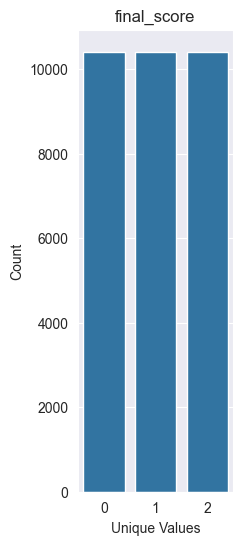

In [112]:
USE_SMOTE = False # Change this flag to True to use SMOTE.

use_balanced = not USE_SMOTE
if use_balanced:
    min_class_count = pd.Series.min(game_results_ready['final_score'].value_counts())  # The count of the smallest class
    # Create a balanced DataFrame by sampling from each class
    balanced_game_results = pd.DataFrame()
    # If a class has fewer instances than the smallest class, we'll need to sample with replacement
    for class_label in game_results_ready['final_score'].unique():
        class_subset = game_results_ready[game_results_ready['final_score'] == class_label]
        if len(class_subset) > min_class_count:
            # If we have more than the minimum class count, we sample without replacement
            class_subset_sample = class_subset.sample(n=min_class_count, random_state=42)
        else:
            # If not, we sample with replacement to boost up to the minimum class count
            class_subset_sample = class_subset.sample(n=min_class_count, random_state=42, replace=True)
        balanced_game_results = pd.concat([balanced_game_results, class_subset_sample], axis=0)
    
    # Update the game_results DataFrame to be the balanced one
    game_results_ready = balanced_game_results
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 6))
sns.countplot(x='final_score', data=game_results_ready)
plt.title('final_score')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

In [113]:
# Now, each class should have the same number of instances
game_results_ready['final_score'].value_counts()

final_score
1    10417
2    10417
0    10417
Name: count, dtype: int64

In [114]:
# Define the classes based on final_score
X = game_results_ready.drop(['final_score'], axis=1)
y = game_results_ready['final_score']
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31251 entries, 31817 to 25147
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neutral                      31251 non-null  int64  
 1   home_code                    31251 non-null  int16  
 2   away_code                    31251 non-null  int64  
 3   hosting_country_code         31251 non-null  int64  
 4   tournament_code              31251 non-null  int64  
 5   home_advantage               31251 non-null  int64  
 6   head_to_head_last_5          31251 non-null  int64  
 7   scored_last_5_home           31251 non-null  int64  
 8   conceded_last_5_home         31251 non-null  int64  
 9   scored_last_5_away           31251 non-null  int64  
 10  conceded_last_5_away         31251 non-null  int64  
 11  goal_difference_last_5_home  31251 non-null  int64  
 12  goal_difference_last_5_away  31251 non-null  int64  
 13  days_since_last_m

In [115]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# 
# game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date','match_id','home_match_id','away_match_id'],axis=1)
# X = game_results_ready.drop(['final_score'], axis=1)
# y = game_results_ready['final_score']
# 
# # Splitting of Data - 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
# svm = svm_ovo = SVC(decision_function_shape='ovo', kernel='linear')
# lr = LogisticRegression(multi_class='multinomial',random_state=42)
# svm_ovo.fit(X_train, y_train)
# lr.fit(X_train,y_train)
# y_pred_ovo = svm_ovo.predict(X_test)
# y_pred_lr = lr.predict(X_test)
# accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# print(f"Accuracy (One-vs-One): {accuracy_ovo}")
# print(f"Accuracy (Logistic Regression): {accuracy_lr}")

### We have our X and y
We will not shuffle because we want our training to happen to the earlier games and our testing to happen to the later games.

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Splitting of Data - 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
use_scaled_data = False
if use_scaled_data:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

### SMOTE-ing
Here we can choose to SMOTE or not..

In [117]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
#use_smote = False # Change this flag to True to use SMOTE.
if USE_SMOTE:
    kn = list(range(2,20,2))
    accuracies = []
    i=0
    while i<len(kn):
        smote = SMOTE(random_state=42,k_neighbors=kn[i],n_jobs=-1)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        from sklearn.ensemble import ExtraTreesClassifier  
        from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
        test_model = ExtraTreesClassifier(criterion='gini',warm_start=True,bootstrap=False,n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators= 400)
        test_model.fit(X_train_smote,y_train_smote)
        y_preds = test_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_preds)
        accuracies.append(accuracy)
        i+=1
    kn_accuracy = {kn[i]:accuracies[i] for i in range(len(kn))}
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(kn, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy vs K-Neighbors')
    plt.xlabel('K-Neighbors')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 31, step=2))  # Adjust x-axis ticks as needed
    plt.yticks(np.arange(0.58, 0.61, step=0.01))  # Adjust y-axis ticks as needed
    plt.grid(True)
    plt.show()
    
    BEST_KN = max(kn_accuracy, key=kn_accuracy.get)

### Model Training Phase 

Multi-Class Model predicts for 3 outcomes : Home win, Home loss, and Tie


Model: Extra Trees Classifier
Accuracy: 0.5828711604095563
              precision    recall  f1-score   support

           0       0.50      0.57      0.54      3125
           1       0.73      0.59      0.65      3125
           2       0.56      0.59      0.57      3126

    accuracy                           0.58      9376
   macro avg       0.60      0.58      0.59      9376
weighted avg       0.60      0.58      0.59      9376

Accuracy: 0.58


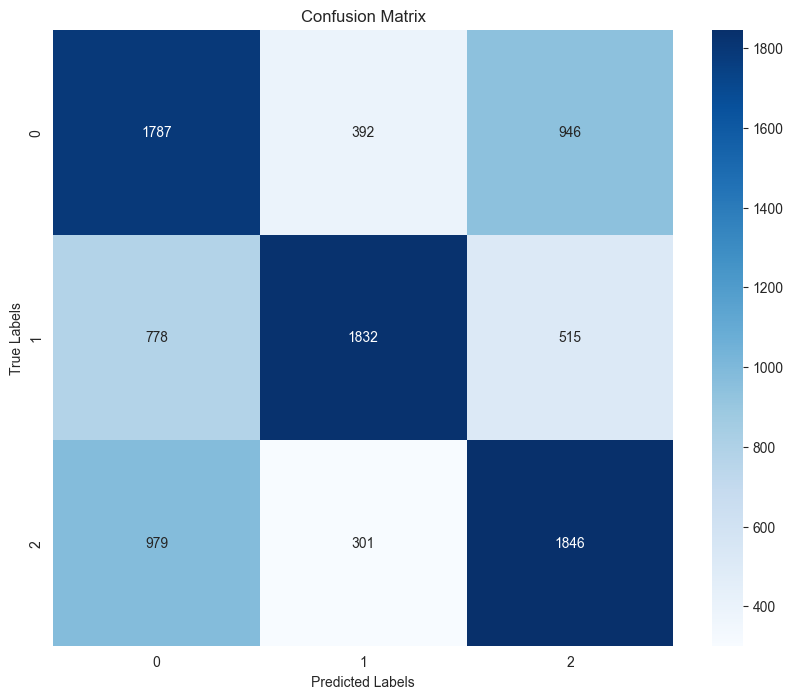

In [118]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,StackingClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomTreesEmbedding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sktime.classification.sklearn import RotationForest
from sklearn.ensemble import BaggingClassifier,StackingClassifier

# Create a RandomForestClassifier model with balanced class weights
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
# main_model = ExtraTreesClassifier(criterion='gini',n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400)
main_model = make_pipeline(RandomTreesEmbedding(n_estimators=400,min_samples_leaf=5, random_state=42), ExtraTreesClassifier(n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400))
# main_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
if USE_SMOTE:
    smote = SMOTE(random_state=42,k_neighbors=BEST_KN,n_jobs=-1)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    main_model.fit(X_train_smote,y_train_smote)
elif use_scaled_data:
    main_model.fit(X_train_scaled,y_train)
else:
    main_model.fit(X_train,y_train)
y_preds = main_model.predict(X_test_scaled) if use_scaled_data else main_model.predict(X_test)
conf_mat = confusion_matrix(y_test,y_preds)
accuracy = accuracy_score(y_test, y_preds)
print(f'Model: Extra Trees Classifier\nAccuracy: {accuracy}')
print(classification_report(y_test, y_preds))
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=main_model.classes_, yticklabels=main_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

```
Accuracy: 0.6813230342642107
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1683
           1       0.77      0.62      0.69      1683
           2       0.67      0.74      0.71      1683

    accuracy                           0.68      5049
   macro avg       0.69      0.68      0.68      5049
weighted avg       0.69      0.68      0.68      5049
```

### Comparison of Results
Prev without scaling:
```
Accuracy: 0.6712220241632006
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1683
           1       0.69      0.64      0.67      1683
           2       0.69      0.73      0.71      1683

    accuracy                           0.67      5049
   macro avg       0.67      0.67      0.67      5049
weighted avg       0.67      0.67      0.67      5049
```
Dry run of dataset as it is, no resampling:
```
Model: Logistic Regression multi-class
Accuracy: 0.5905166312809625
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1969
           1       0.38      0.12      0.19      1683
           2       0.63      0.85      0.73      3413

    accuracy                           0.59      7065
   macro avg       0.52      0.50      0.49      7065
weighted avg       0.55      0.59      0.55      7065
```

Undersampled dataset with ExtraTreesClassifier:
```
Accuracy: 0.678748266983561
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1683
           1       0.76      0.62      0.68      1683
           2       0.67      0.74      0.71      1683

    accuracy                           0.68      5049
   macro avg       0.69      0.68      0.68      5049
weighted avg       0.69      0.68      0.68      5049
```

SMOTE oversample BOOTSTRAP=TRUE:
```
Accuracy: 0.5985845718329795
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      1969
           1       0.40      0.27      0.32      1683
           2       0.69      0.79      0.74      3413

    accuracy                           0.60      7065
   macro avg       0.54      0.54      0.53      7065
weighted avg       0.58      0.60      0.58      7065
```
Undersampled dataset with BOOTSTRAP=TRUE
```
Accuracy: 0.6726084373143196
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1683
           1       0.70      0.65      0.67      1683
           2       0.69      0.73      0.71      1683

    accuracy                           0.67      5049
   macro avg       0.67      0.67      0.67      5049
weighted avg       0.67      0.67      0.67      5049
```



### Comparing to different models

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import ElasticNet, RidgeClassifier, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sktime.classification.sklearn import RotationForest
from sklearn.ensemble import RandomTreesEmbedding, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier,StackingClassifier
compare = False
if compare:
    lasso_binary = Lasso(alpha=0.1) 
    elastic_net_binary = ElasticNet(alpha=0.1, l1_ratio=0.5)
    models = {
        'SVM': SVC(decision_function_shape='ovo',random_state=42,kernel='rbf'),
        'Logistic_Multi': LogisticRegression(multi_class='multinomial',random_state=42,max_iter=100000),
        'Gradient Boosting Classifier (400 estimators)': GradientBoostingClassifier(n_estimators=400, random_state=42),
        'Bagging Classifier':BaggingClassifier(n_estimators=200, max_samples=1.0, max_features=0.8, random_state=42,bootstrap=False),
        # 'Ridge': RidgeClassifier(alpha=1.0),
        # 'QuadDA':QuadraticDiscriminantAnalysis(),
        # 'Lasso':OneVsRestClassifier(lasso_binary),
        # 'Elastic Net':OneVsRestClassifier(elastic_net_binary),
        # 'hard voting classifier (ExtraTrees+GBoost+RandomForest)': VotingClassifier(estimators=[
        # ('extra_trees', ExtraTreesClassifier(criterion='gini',max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400)),
        # ('gradient_boosting', GradientBoostingClassifier(n_estimators=400, random_state=42)),
        # ('random_forest', RandomForestClassifier(n_estimators=100))], voting='hard'),
    #     'Stacking with random forest, gradient boost, and extra trees. Final estimator is logistic regression': StackingClassifier(estimators= [
    #     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    #     ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    #         ('et',ExtraTreesClassifier(n_estimators=400,criterion='entropy',warm_start=False,bootstrap=False),)
    # ], final_estimator=SVC(kernel='linear',random_state=42)),
        #     'RandomForestClassifier':RandomForestClassifier(n_estimators=250,bootstrap=False,n_jobs=1,random_state=42),
        # 'ExtraTrees with Entropy':ExtraTreesClassifier(n_estimators=400,criterion='entropy',warm_start=False,bootstrap=False),
        # 'Rotational_Forest': RotationForest(n_estimators=100),
        'Random Tree Embedding': make_pipeline(RandomTreesEmbedding(n_estimators=400,min_samples_leaf=5, random_state=42), ExtraTreesClassifier(criterion='gini',n_jobs=-1,max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=400)),
        # 'Random Subspace (Pasting)':BaggingClassifier(estimator=ExtraTreesClassifier(), n_estimators=400, max_samples=1.0, max_features=0.8, random_state=42,bootstrap=False)
    }
    models_preds = {key:0 for key in models.keys()}
    for model in models.keys():
        print(model)
        if USE_SMOTE:
            models[model].fit(X_train_smote,y_train_smote)
        elif use_scaled_data:
            models[model].fit(X_train_scaled,y_train)
        else:
            models[model].fit(X_train,y_train)
        y_pred = models[model].predict(X_test_scaled) if use_scaled_data else models[model].predict(X_test)
        print(f'done predicting')
        models_preds[model] = y_pred

### Let's evaluate the models

In [41]:
print('test')
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
if compare:
    models_mtxs =  {key:0 for key in models.keys()}
    for model in models_preds.keys():
        conf_mtx = confusion_matrix(y_test,models_preds[model])
        accuracy = accuracy_score(y_test, models_preds[model])
        print(f'Model: {model}\nAccuracy: {accuracy}')
        print(classification_report(y_test, models_preds[model]))
        models_mtxs[model] = conf_mtx

test


In [219]:
import seaborn as sns
import matplotlib.pyplot as plt
if compare:
    for mtx in models_mtxs.keys():
        sns.heatmap(models_mtxs[mtx], annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {mtx}')
        plt.show()

### Extras: Match creator to predict the outcome of a tournament

In [220]:
# tournament code 0 as default -> Tournament
def match_creator(team_1,team_2,tournament_code=0):
    # Get home and away codes
    home_code,away_code = country_codes[team_1],country_codes[team_2]
    # Randomize if game is played at neutral ground
    neutral = random.randint(0,1)
    # if not on neutral ground, pick either home or away as playing ground. Else pick a random ground
    hosting_country_code = random.choice([home_code,away_code]) if not neutral else random.choice(list(country_codes.values()))
    home_advantage = (country_codes[team_1] == hosting_country_code)
    game_info = {
        'home_team':team_1,
        'away_team':team_2,
        'date':datetime.now()
    }
    head_to_head_last_5 = calculate_head_to_head(game_info)
    goal_difference_last_5_home = calculate_goal_difference_last_5(game_info,'home_team')
    goal_difference_last_5_away = calculate_goal_difference_last_5(game_info,'away_team')
    days_since_last_match_home:pd.Series = (datetime.now() - game_results.loc[game_results['home_team'] == team_1].tail(1)['date']).to_list()[0].days
    days_since_last_match_away = (datetime.now() - game_results.loc[game_results['away_team'] == team_2].tail(1)['date']).to_list()[0].days
    wins_last_10_games_home = game_results.loc[(game_results['home_team'] == team_1)]['final_score'].eq(2).sum() + game_results.loc[(game_results['away_team'] == team_1)]['final_score'].eq(0).sum()
    wins_last_10_games_away = game_results.loc[(game_results['home_team'] == team_2)]['final_score'].eq(2).sum() + game_results.loc[(game_results['away_team'] == team_2)]['final_score'].eq(0).sum()
    scored_last_5_home =  game_results.loc[(game_results['home_team'] == team_1)].tail(5)['home_score'].sum() + game_results.loc[(game_results['away_team'] == team_1)].tail(5)['away_score'].sum()
    scored_last_5_away = game_results.loc[(game_results['home_team'] == team_2)].tail(5)['home_score'].sum() + game_results.loc[(game_results['away_team'] == team_2)].tail(5)['away_score'].sum()
    
    conceded_last_5_home = game_results.loc[(game_results['home_team'] == team_1)].tail(5)['away_score'].sum() + game_results.loc[(game_results['away_team'] == team_1)].tail(5)['home_score'].sum()
    
    conceded_last_5_away = game_results.loc[(game_results['home_team'] == team_2)].tail(5)['away_score'].sum() + game_results.loc[(game_results['away_team'] == team_2)].tail(5)['home_score'].sum()
    match_data = {
        'neutral': neutral,
        'home_code':home_code,
        'away_code':away_code,
        'hosting_country_code':hosting_country_code,
        'tournament_code':tournament_code,
        'home_advantage':home_advantage,
        'head_to_head_last_5':head_to_head_last_5,
        'goal_difference_last_5_home':goal_difference_last_5_home,
        'goal_difference_last_5_away':goal_difference_last_5_away,
        'days_since_last_match_home':days_since_last_match_home,
        'days_since_last_match_away':days_since_last_match_away,
        'scored_last_5_home':scored_last_5_home,
        'scored_last_5_away':scored_last_5_away,
        'conceded_last_5_home':conceded_last_5_home,
        'conceded_last_5_away':conceded_last_5_away, 
        'wins_last_10_games_home':wins_last_10_games_home,
        'wins_last_10_games_away':wins_last_10_games_away
    }
    match_idx = match_data.keys()
    return pd.Series(data=match_data.values(),index=match_idx).values.reshape(1,-1)

### USA vs Saudi Arabia

In [221]:
team_1, team_2 = 'United States','Saudi Arabia'
my_match = match_creator(team_1, team_2)

In [222]:
team_1 if main_model.predict(my_match) == 2 else team_2

'Saudi Arabia'

### Let's run our own little tournament!

In [223]:
countries_to_match = ['Belgium','United States','Japan','Qatar','Saudi Arabia','England','Scotland','France','Brazil','Italy','Germany','Uruguay','Argentina','Spain','Mexico','Australia'] 

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
def run_tournament(teams,tournament_type='cup',hosting_country='random',with_print=True):
    if not teams:
        return 
    # Randomize teams
    random.shuffle(teams)
    # If tournament_type is 'cup' then draws are not allowed. One team must win!
    tab=''
    while len(teams) != 1:
        winners = []
        for i in range(0,len(teams),2):
            match = match_creator(teams[i],teams[i+1])
            if hosting_country != 'random':
                match = change_host(match,hosting_country,teams,i)
                # match[0][3] = country_codes[hosting_country]
                # match[0][0] = (match[0][3] != teams[i]) and (match[0][3] != teams[i+1])
                # match[0][8] = match[0][3] == teams[i]
            if len(teams) == 2: tab+='Final:'
            if with_print: print(tab,teams[i],'vs',teams[i+1],end=' -> ')
            # Initial prediction
            pred = main_model.predict(match)
            if pred == 1 and tournament_type == 'cup':
                if with_print: print('Tie at full time. Playing extra-time.',end=' -> ')
                match = match_creator(teams[i],teams[i+1],tournament_code=1) # Make the game more serious
                if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                pred = main_model.predict(match)
                if pred == 1:
                    if with_print: print('Tie at extra time. Playing penalty shoot-outs.',end=' -> ')
                    match = match_creator(teams[i],teams[i+1],tournament_code=1)
                    if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                    pred = main_model.predict(match)
                    if pred == 1:
                        # Penalties are random anyway!
                        winner = teams[i] if random.randint(0,99) % 2 == 0 else teams[i+1]
                    else: 
                        winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after penalty shoot-outs!')
                else:
                    winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after extra time.')
            else:
                winner = teams[i] if pred == 2 else teams[i+1]
                if with_print: print(winner,'won after full time.')
            winners.append(winner)
        teams.clear()
        teams = winners
        tab+='\t'
    return teams[0]

def change_host(match,host,teams,i):
    match[0][3] = country_codes[host]
    match[0][0] = (match[0][3] != teams[i]) and (match[0][3] != teams[i+1])
    match[0][8] = match[0][3] == teams[i]
    return match
run_tournament(countries_to_match)

 Italy vs Uruguay -> Uruguay won after full time.
 Australia vs Brazil -> Brazil won after full time.
 United States vs Spain -> United States won after full time.
 Belgium vs England -> England won after full time.
 France vs Qatar -> France won after full time.
 Saudi Arabia vs Japan -> Japan won after full time.
 Germany vs Argentina -> Argentina won after full time.
 Mexico vs Scotland -> Tie at full time. Playing extra-time. -> Mexico won after extra time.
	 Uruguay vs Brazil -> Brazil won after full time.
	 United States vs England -> United States won after full time.
	 France vs Japan -> Japan won after full time.
	 Argentina vs Mexico -> Mexico won after full time.
		 Brazil vs United States -> Brazil won after full time.
		 Japan vs Mexico -> Japan won after full time.
			Final: Brazil vs Japan -> Brazil won after full time.


'Brazil'

In [224]:
def get_valid_countries(k):
    all_countries = list(game_results_ready.index.values)
    # For some reason these countries cause issues
    all_countries.remove('Yugoslavia')
    all_countries.remove('Serbia and Montenegro')
    all_countries.remove('Czechoslovakia')
    all_countries.remove('Netherlands Antilles')
    valid_countries = set()
    while len(valid_countries) != k:
        curr_country = random.choice(all_countries)
        val = country_codes.setdefault(curr_country,-1)
        if val != -1: valid_countries.add(curr_country)
    return list(valid_countries)

### Let's generate random countries and create a 32-team tournament

In [225]:
my_tournament = get_valid_countries(32)
country_ranks = {country:rank_at_year_df.loc[country,int(datetime.now().year)] for country in my_tournament}
best_rank = min(country_ranks.values())
best_country = list(filter(lambda x: country_ranks[x] == best_rank,country_ranks.keys()))[0]
avg_rank = sum(country_ranks.values())/len(country_ranks.values())
print('Best country: {} - Ranked {}\nAverage Team Rank: {}'.format(best_country,best_rank,avg_rank))

Best country: Argentina - Ranked 1.0
Average Team Rank: 112.9375


In [226]:
# Designate a country to host the tournament
host = 'England'
winner = run_tournament(my_tournament,hosting_country=host,with_print=True)
print(winner,'wins the tournament!')
if winner != best_country:
    print('What a great tournament!')
else:
    print('The best team won, as expected.')
print('Tournament hosted by',host)

 Hong Kong vs Slovakia -> Slovakia won after full time.
 Mongolia vs Grenada -> Grenada won after full time.
 Uzbekistan vs Paraguay -> Paraguay won after full time.
 Puerto Rico vs Czech Republic -> Puerto Rico won after full time.
 Bolivia vs Sri Lanka -> Bolivia won after full time.
 Singapore vs Sweden -> Sweden won after full time.
 Oman vs Kosovo -> Oman won after full time.
 Romania vs Georgia -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Georgia won after penalty shoot-outs!
 Argentina vs Ecuador -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Ecuador won after penalty shoot-outs!
 Israel vs Cyprus -> Tie at full time. Playing extra-time. -> Tie at extra time. Playing penalty shoot-outs. -> Israel won after penalty shoot-outs!
 Croatia vs Turkey -> Croatia won after full time.
 South Sudan vs Timor-Leste -> South Sudan won after full time.
 Iraq vs Italy -> Italy won after full time.
 

In [232]:
i = 0
WC_wins = dict()
runs = 250
num_teams = 32
host='England'
while i != runs:
    world_cup = get_valid_countries(num_teams)
    country_ranks = {country:rank_at_year_df.loc[country,2023] for country in world_cup}
    best_rank = min(country_ranks.values())
    best_country = list(filter(lambda x: country_ranks[x] == best_rank,country_ranks.keys()))[0]
    print('run {} - Highest ranked team: {} Rank {}'.format(i,best_country,best_rank))
    winner = run_tournament(teams=world_cup,hosting_country=host,with_print=False)
    WC_wins[winner] = (WC_wins.get(winner,0) + 1)
    i+=1
stats = dict()
for winner in WC_wins.keys():
    stats[winner] = WC_wins.get(winner)/runs
display(stats)

run 0 - Highest ranked team: Italy Rank 8.0
run 1 - Highest ranked team: Argentina Rank 1.0
run 2 - Highest ranked team: Portugal Rank 9.0
run 3 - Highest ranked team: Belgium Rank 4.0
run 4 - Highest ranked team: Portugal Rank 9.0
run 5 - Highest ranked team: France Rank 2.0
run 6 - Highest ranked team: France Rank 2.0
run 7 - Highest ranked team: England Rank 5.0
run 8 - Highest ranked team: Croatia Rank 7.0
run 9 - Highest ranked team: Argentina Rank 1.0
run 10 - Highest ranked team: England Rank 5.0
run 11 - Highest ranked team: Belgium Rank 4.0
run 12 - Highest ranked team: Croatia Rank 7.0
run 13 - Highest ranked team: France Rank 2.0
run 14 - Highest ranked team: Belgium Rank 4.0
run 15 - Highest ranked team: Belgium Rank 4.0
run 16 - Highest ranked team: Denmark Rank 19.0
run 17 - Highest ranked team: Mexico Rank 15.0
run 18 - Highest ranked team: Uruguay Rank 16.0
run 19 - Highest ranked team: Portugal Rank 9.0
run 20 - Highest ranked team: Italy Rank 8.0
run 21 - Highest rank

{'Switzerland': 0.068,
 'Argentina': 0.052,
 'Portugal': 0.076,
 'France': 0.072,
 'Denmark': 0.056,
 'Canada': 0.004,
 'Uruguay': 0.024,
 'England': 0.06,
 'Croatia': 0.06,
 'Colombia': 0.016,
 'Belgium': 0.048,
 'Sweden': 0.02,
 'Ukraine': 0.004,
 'Italy': 0.04,
 'Austria': 0.004,
 'Brazil': 0.044,
 'Germany': 0.024,
 'Saudi Arabia': 0.012,
 'Japan': 0.028,
 'Morocco': 0.04,
 'Senegal': 0.02,
 'Netherlands': 0.028,
 'United States': 0.028,
 'Nigeria': 0.004,
 'Finland': 0.004,
 'Hungary': 0.012,
 'Chile': 0.012,
 'Paraguay': 0.004,
 'Mexico': 0.016,
 'Serbia': 0.012,
 'Peru': 0.016,
 'Spain': 0.028,
 'Republic of Ireland': 0.004,
 'Cameroon': 0.004,
 'Burkina Faso': 0.004,
 'Costa Rica': 0.008,
 'Tunisia': 0.012,
 'Wales': 0.008,
 'Poland': 0.008,
 'Ecuador': 0.004,
 'Australia': 0.004,
 'Algeria': 0.004,
 'Ghana': 0.004}

In [233]:
print('test')
sorted_dict = sorted(WC_wins.items(), key=lambda x:x[1])
for winner in sorted_dict[-10:]:
    rank = rank_at_year_df.loc[winner[0],2023]
    print(f'Team: {winner[0]:<20} Win%: {winner[1]:<2}% {" "*3:<10}FIFA Ranking 2023: {rank:<15}')

test
Team: Morocco              Win%: 10%           FIFA Ranking 2023: 11.0           
Team: Brazil               Win%: 11%           FIFA Ranking 2023: 3.0            
Team: Belgium              Win%: 12%           FIFA Ranking 2023: 4.0            
Team: Argentina            Win%: 13%           FIFA Ranking 2023: 1.0            
Team: Denmark              Win%: 14%           FIFA Ranking 2023: 19.0           
Team: England              Win%: 15%           FIFA Ranking 2023: 5.0            
Team: Croatia              Win%: 15%           FIFA Ranking 2023: 7.0            
Team: Switzerland          Win%: 17%           FIFA Ranking 2023: 12.0           
Team: France               Win%: 18%           FIFA Ranking 2023: 2.0            
Team: Portugal             Win%: 19%           FIFA Ranking 2023: 9.0            


### Optimization part

In [229]:
perform_gridsearch = False
if perform_gridsearch:
    from sklearn.metrics import make_scorer, precision_score
    from sklearn.model_selection import GridSearchCV
    import warnings
    
    # Suppress FutureWarning messages
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)
    
    param_grid = {
        'base_estimator__n_estimators': [50, 100, 200,300,400],
        'base_estimator__max_depth': [None, 10, 20],
        'max_samples': [0.8, 1.0],
        'max_features': [0.8, 1.0]
    }
    # Create a Random Subspace Classifier pipeline
    random_subspace_model = BaggingClassifier(base_estimator=ExtraTreesClassifier(random_state=42), random_state=42)
    scorer = make_scorer(precision_score, average='macro')
    grid_search = GridSearchCV(estimator=random_subspace_model, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and corresponding precision score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Precision Score:", grid_search.best_score_)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)

```
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}
Best Precision Score: 0.6496295887336865

Best Parameters: {'base_estimator__max_depth': None, 'base_estimator__n_estimators': 50, 'max_features': 0.8, 'max_samples': 1.0}
Best Precision Score: 0.6331092403002385
```